In [1]:
import re
import os
import scipy.stats
import numpy as np
import pandas as pd
from tests import *
from matplotlib import pyplot as plt
from helpers import *

# Reading Data

In [2]:
dict_of_announcements = pd.read_pickle(r'parsed_announcements_november.pkl')
df = pd.DataFrame(dict_of_announcements)

# Exploring price

In [3]:
df = df.drop(df[df['price'].apply(lambda x: '/ lună' in x)].index).reset_index(drop=True)
df['eur_price'] = df['price'].apply(lambda x: get_eur_price(x))
df['eur_price'] = np.where(
    (df['eur_price'] <= 140000) & (df['price'].apply(lambda x: 'TVA' in x)),
    df['eur_price'] * 1.05,
    np.where(
        (df['eur_price'] > 140000) & (df['price'].apply(lambda x: 'TVA' in x)),
        df['eur_price'] * 1.19,
        df['eur_price']
    )
)

### Just as expected, the price follows a lognormal distribution, with most prices being concentrated around the median, and a few significantly more expensive properties

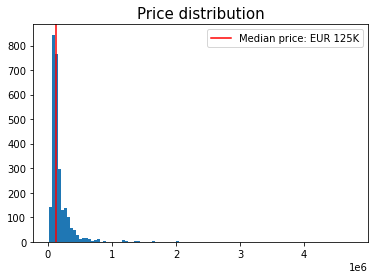

In [4]:
plt.hist(df['eur_price'], bins=100)
median_price = int(df['eur_price'].median())
plt.axvline(median_price, color='red', label=f'Median price: EUR {int(median_price/1000)}K')
plt.title('Price distribution', fontsize=15)
plt.legend();

In [5]:
original_cols = ['Nr. camere', 'Suprafaţă utilă', 'Compartimentare', 'Confort', 'Etaj', 'Nr. bucătării', 'Nr. băi', 'An construcţie', 'Structură rezistenţă', 'Tip imobil', 'Nr. balcoane', 'Nr. locuri parcare', 'Nr. garaje']
new_cols = ['rooms', 'surface_area', 'partitioning_type', 'comfort_type', 'floors', 'kitchens', 'bathrooms', 'building_year', 'building_structure', 'building_type', 'balconies', 'parking_spots', 'garages']
df.rename(columns={original_cols[i]: new_cols[i] for i in range(len(original_cols))}, inplace=True)

### Some fields are absolutely critical, and cannot be recreated if they are missing. Therefore, the only solution is to drop them

In [6]:
faulty_rows = ((df['rooms'].isnull()) | 
    (df['surface_area'].isnull()) | 
    (df['building_year'].isnull()) |
    (df['floors'].apply(lambda x: '/' not in x))).sum()
print(f'There are {faulty_rows} rows with critical missing data, roughly {round(faulty_rows/len(df), 3)*100}% of rows')

There are 113 rows with critical missing data, roughly 4.2% of rows


In [7]:
df.drop(df[
    (df['rooms'].isnull()) | 
    (df['surface_area'].isnull()) | 
    (df['building_year'].isnull()) |
    (df['floors'].apply(lambda x: '/' not in x))
].index, inplace=True)
df['rooms'] = df['rooms'].astype(int)
df['surface_area'] = df['surface_area'].apply(lambda x: x.split(' ')[0].strip().replace(',', '.')).astype(float)
df.reset_index(drop=True, inplace=True)

### Partition Type

In [8]:
df['partitioning_type'].value_counts(dropna=False)

decomandat        1580
semidecomandat     867
NaN                 65
nedecomandat        20
circular            14
Name: partitioning_type, dtype: int64

In [9]:
df['partitioning_type'].value_counts(dropna=False)/len(df)

decomandat        0.620581
semidecomandat    0.340534
NaN               0.025530
nedecomandat      0.007855
circular          0.005499
Name: partitioning_type, dtype: float64

In [10]:
df['partition_decomandat'] = (df['partitioning_type'] == 'decomandat').astype(int)
df['partition_other'] = (df['partitioning_type'] != 'decomandat').astype(int)

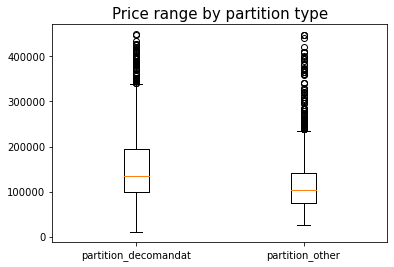

In [11]:
percentile_95_price = np.percentile(df['eur_price'], 95)
data = [
    df[
        (df['partition_decomandat'] == 1) & 
        (df['eur_price'] < percentile_95_price)
    ]['eur_price'], 
    df[
        (df['partition_other'] == 1) & 
        (df['eur_price'] < percentile_95_price)
    ]['eur_price']
]
fig7, ax7 = plt.subplots()
ax7.set_title('Price range by partition type', fontsize=15)
ax7.boxplot(data)
plt.xticks([1, 2] , ['partition_decomandat', 'partition_other'])
plt.show();

### Comfort Type

In [12]:
df['comfort_type'].value_counts(dropna=False) / len(df)

1      0.686960
lux    0.263551
NaN    0.037706
2      0.009427
3      0.002357
Name: comfort_type, dtype: float64

In [13]:
df['comfort_other'] = (~df['comfort_type'].isin(['1', 'lux'])).astype(int)
df['comfort_1'] = (df['comfort_type'] == '1').astype(int)
df['comfort_lux'] = (df['comfort_type'] == 'lux').astype(int)

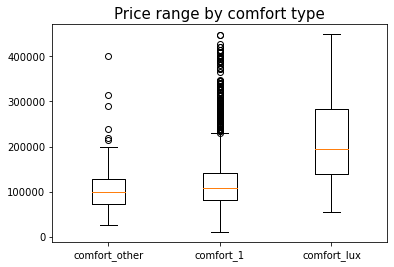

In [14]:
percentile_95_price = np.percentile(df['eur_price'], 95)
data = [
    df[
        (df['comfort_other'] == 1) & 
        (df['eur_price'] < percentile_95_price)
    ]['eur_price'], 
    df[
        (df['comfort_1'] == 1) & 
        (df['eur_price'] < percentile_95_price)
    ]['eur_price'],
    df[
        (df['comfort_lux'] == 1) & 
        (df['eur_price'] < percentile_95_price)
    ]['eur_price']
]
fig7, ax7 = plt.subplots()
ax7.set_title('Price range by comfort type', fontsize=15)
ax7.boxplot(data)
plt.xticks([1, 2, 3] , ['comfort_other', 'comfort_1', 'comfort_lux'])
plt.show();

### Apartment floors

In [15]:
floor_series = df['floors'].apply(lambda x: x.split('/')[0]).reset_index(drop=True)
max_floor_series = df['floors'].apply(lambda x: x.split('/')[-1].strip()).astype(int).reset_index(drop=True)
floor_series = pd.Series(
        np.where(
        floor_series.apply(lambda x: any([val in x.lower() for val in ['parter', 'demi']])),
        '0',
        np.where(
            floor_series.apply(lambda x: any([val in x.lower() for val in ['ultim', 'mansard']])),
            '99',
            floor_series
        )
    )
).apply(lambda x: re.findall(r'\d+', x)[0]).astype(int)
df['floor'] = np.where(
    floor_series == 0,
    'first_floor',
    np.where(
        floor_series >= max_floor_series,
        'last_floor',
        'middle_floor'
    )
)
df['max_floor'] = max_floor_series
df = pd.concat([df, pd.get_dummies(df['floor'].astype(pd.CategoricalDtype(categories=FLOOR_CATEGORIES)))], axis=1)

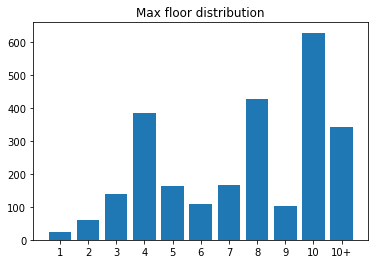

In [38]:
max_floors_value_counts = df['max_floor'].apply(lambda x: str(x) if x <= 10 else '10+').value_counts().reset_index()
max_floor_types = [str(x) for x in range(1, 11)] + ['10+']
max_floor_counts = [max_floors_value_counts[max_floors_value_counts['index'] == val]['max_floor'].values[0] for val in max_floor_types]
plt.bar(max_floor_types, max_floor_counts)
plt.title('Max floor distribution');

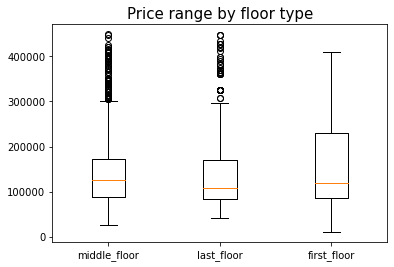

In [44]:
percentile_95_price = np.percentile(df['eur_price'], 95)
data = [
    df[
        (df['middle_floor'] == 1) & 
        (df['eur_price'] < percentile_95_price)
    ]['eur_price'], 
    df[
        (df['last_floor'] == 1) & 
        (df['eur_price'] < percentile_95_price)
    ]['eur_price'],
    df[
        (df['first_floor'] == 1) & 
        (df['eur_price'] < percentile_95_price)
    ]['eur_price']
]
fig7, ax7 = plt.subplots()
ax7.set_title('Price range by floor type', fontsize=15)
ax7.boxplot(data)
plt.xticks([1, 2, 3] , ['middle_floor', 'last_floor', 'first_floor'])
plt.show();

### Building year

In [55]:
df['building_year'] = df['building_year'].apply(lambda x: 'not_finished' if 'constructie' in x else x)
df['building_year'] = df['building_year'].apply(lambda x: 'not_started' if 'proiect' in x else x)
df['building_year'] = df['building_year'].apply(lambda x: x.replace('(finalizata)', '').strip())
df['building_year'] = df['building_year'].apply(lambda x: translate_building_year_values(x))
df['building_year'] = df['building_year'].apply(lambda x: get_building_year_category(x))
df = pd.concat([df, pd.get_dummies(df['building_year'].astype(pd.CategoricalDtype(categories=BUILDING_PERIODS)))], axis=1)

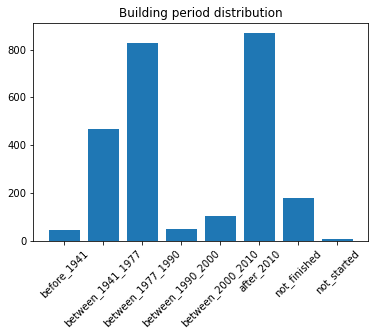

In [61]:
building_year_value_counts = df['building_year'].value_counts().reset_index()
building_period_counts = [building_year_value_counts[building_year_value_counts['index'] == val]['building_year'].values[0] for val in BUILDING_PERIODS]
plt.bar(BUILDING_PERIODS, building_period_counts)
plt.xticks(range(len(BUILDING_PERIODS)), BUILDING_PERIODS, rotation=45)
plt.title('Building period distribution');

In [62]:
BUILDING_PERIODS

['before_1941',
 'between_1941_1977',
 'between_1977_1990',
 'between_1990_2000',
 'between_2000_2010',
 'after_2010',
 'not_finished',
 'not_started']

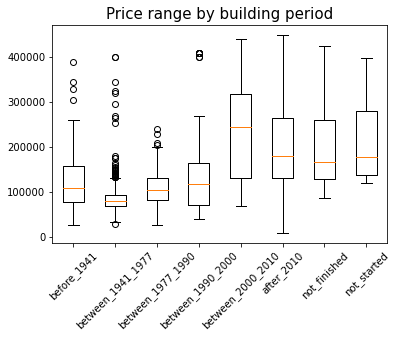

In [68]:
percentile_95_price = np.percentile(df['eur_price'], 95)
data = [
    df[
        (df['before_1941'] == 1) & 
        (df['eur_price'] < percentile_95_price)
    ]['eur_price'], 
    df[
        (df['between_1941_1977'] == 1) & 
        (df['eur_price'] < percentile_95_price)
    ]['eur_price'],
    df[
        (df['between_1977_1990'] == 1) & 
        (df['eur_price'] < percentile_95_price)
    ]['eur_price'],
    df[
        (df['between_1990_2000'] == 1) & 
        (df['eur_price'] < percentile_95_price)
    ]['eur_price'],
    df[
        (df['between_2000_2010'] == 1) & 
        (df['eur_price'] < percentile_95_price)
    ]['eur_price'],
    df[
        (df['after_2010'] == 1) & 
        (df['eur_price'] < percentile_95_price)
    ]['eur_price'],
    df[
        (df['not_finished'] == 1) & 
        (df['eur_price'] < percentile_95_price)
    ]['eur_price'],
    df[
        (df['not_started'] == 1) & 
        (df['eur_price'] < percentile_95_price)
    ]['eur_price']
]
fig7, ax7 = plt.subplots()
ax7.set_title('Price range by building period', fontsize=15)
ax7.boxplot(data)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8] , BUILDING_PERIODS, rotation=45)
plt.show();